In [1]:
import msprime
import demes


def whatis_example():
    demes_yml = """\
        description:
          Asymmetric migration between two extant demes.
        time_units: generations
        defaults:
          epoch:
            start_size: 5000
        demes:
          - name: Ancestral_population
            epochs:
              - end_time: 1000
          - name: A
            ancestors: [Ancestral_population]
          - name: B
            ancestors: [Ancestral_population]
            epochs:
              - start_size: 2000
                end_time: 500
              - start_size: 400
                end_size: 10000
        migrations:
          - source: A
            dest: B
            rate: 1e-4
        """
    with open("data/whatis_example.yml", "wt") as f:
        f.write(demes_yml)
    graph = demes.loads(demes_yml)
    demography = msprime.Demography.from_demes(graph)
    # Choose seed so num_trees=3, tips are in same order, and all trees have the same root
    seed = 1320
    ts = msprime.sim_ancestry(
        samples={"A": 2, "B": 3},
        demography=demography,
        recombination_rate=1e-8,
        sequence_length=1000,
        random_seed=seed)
    # Mutate
    # Choose seed to give 10 muts, 1 in last tree above node 18, none above 0 in first tree
    seed = 5535
    ts = msprime.sim_mutations(ts, rate=1e-7, random_seed=seed)
    ts.dump("data/whatis_example.trees")

def create_notebook_data():
    whatis_example()

# create_notebook_data()  # uncomment to recreate the tree seqs used in this notebook

(sec_what_is)=

# What is a tree sequence?

A *succinct tree sequence*, or "tree sequence" for short, represents the evolutionary
relationships between a set of DNA sequences. Tree sequences are based on fundamental
biological principles of inheritance, DNA duplication, and recombination; they can be
created by [simulation](https://tskit.dev/software/#simulate) or by
[inferring relationships from empirical DNA data](https://tskit.dev/software/#infer).

:::{margin} Key point
Tree sequences are used to encode and analyse large genetic datasets
:::

Tree sequences provide an efficient way of storing
[genetic variation](https://en.wikipedia.org/wiki/Genetic_variation) data, and can
power analyses of millions of whole [genomes](https://en.wikipedia.org/wiki/Genome).
Plots (a) and (b) summarize results presented
[further](plot_storing_everyone) [down](plot_incremental_calculation) this tutorial.

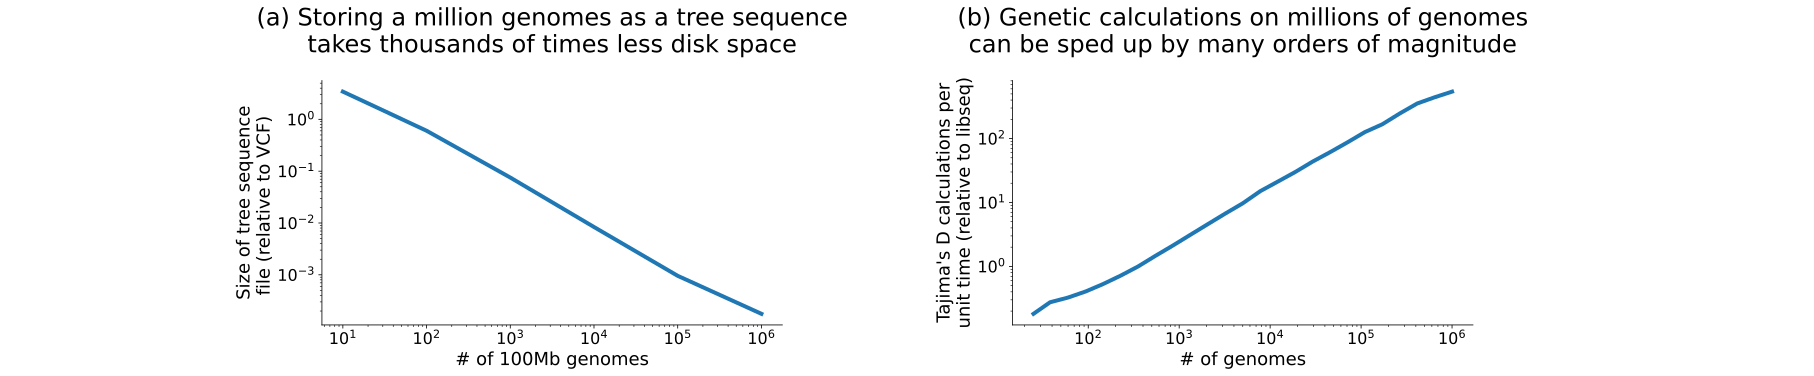

In [2]:
# This cell deliberately removed (not just hidden via a toggle) as it's not helpful
# for understanding tskit code (it's merely plotting code)
from IPython.display import SVG
import matplotlib_inline
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

data1 = np.genfromtxt("data/storing_everyone.csv", delimiter=",", usecols=np.arange(1,12), names=True)
data2 = np.genfromtxt("data/benchmarks_without_copy_longer_genome.txt", encoding=None, names=True, dtype=None)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4.5))
fig.subplots_adjust(wspace=0.5, left=0, right=1)
keep = data1['sample_size'] <= 1e6
x, y = data1['sample_size'][keep], data1['tsk_fit'][keep]/data1['vcf_fit'][keep]
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.loglog(x, y, c="C0", linewidth=4)
ax1.set_xlabel('# of 100Mb genomes', fontsize=18)
ax1.set_ylabel('Size of tree sequence\nfile (relative to VCF) ', fontsize=18)
ax1.tick_params(axis="both", labelsize=16)

txt = ax1.text(0.5, 1.3, "(a) Storing a million genomes as a tree sequence takes thousands of times less disk space",
    ha='center', va='top', transform=ax1.transAxes, wrap=True, size=24)
txt._get_wrap_line_width = lambda: 600

ts_time = {n: t for s, n, t in data2[['toolkit','nsam','seconds']] if s == 'tskit'}
libseq_time = {n: t for s, n, t in data2[['toolkit','nsam','seconds']] if s == 'libseq'}
x = np.unique(list(ts_time.keys()) + list(libseq_time.keys()))
y = np.array([libseq_time[time]/ts_time[time] for time in x])
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.loglog(x, y, linewidth=4)
ax2.set_xlabel("# of genomes", fontsize=18)
ax2.set_ylabel("Tajima's D calculations per\nunit time (relative to libseq)", fontsize=18)
ax2.tick_params(axis="both", labelsize=16)
txt = ax2.text(0.5, 1.3, "(b) Genetic calculations on millions of genomes can be sped up by many orders of magnitude",
    ha='center', va='top', transform=ax2.transAxes, wrap=True, size=24
)    
txt._get_wrap_line_width = lambda: 600
plt.show()

As the name suggests, the simplest way to think
about a tree sequence is as a sequence of "local trees" --- i.e. trees located at
different points along the [chromosome](https://en.wikipedia.org/wiki/Chromosome).
Here's a tiny example based on ten genomes, $\mathrm{a}$ to $\mathrm{j}$, spanning
a short 1000 letter chromosome.

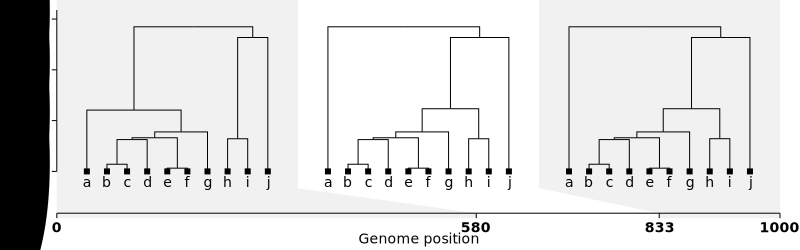

In [3]:
import string
import tskit
from IPython.display import SVG

mutated_ts = tskit.load("data/whatis_example.trees")
ts = mutated_ts.delete_sites(list(range(mutated_ts.num_sites)))
# Extra code to label and order the tips alphabetically rather than numerically
labels = {i: string.ascii_lowercase[i] for i in range(ts.num_nodes)}
genome_order = [n for n in ts.first().nodes(order="minlex_postorder") if ts.node(n).is_sample()]
labels.update({n: labels[i] for i, n in enumerate(genome_order)})
style1 = (
    ".node:not(.sample) > .sym, .node:not(.sample) > .lab {visibility: hidden;}"
    ".mut {font-size: 12px} .y-axis .tick .lab {font-size: 85%}")
sz = (800, 250)  # size of the plot, slightly larger than the default
ticks = [0, 5000, 10000, 15000, 20000]
SVG(ts.draw_svg(
    size=sz, node_labels=labels, style=style1, y_label="Time ago",
    y_axis=True, y_ticks=ticks))

::::{margin}
:::{note}
For clarity in these examples, we are using letters to label nodes. Normally, however,
the nodes are referred to by {ref}`numerical ID<sec_terminology_nodes>`.
:::
::::

The tickmarks on the X axis and background shading indicate the genomic positions covered
by the trees. For just over half the chromosome, from the
start until position 580, the relationships between the ten genomes are shown by
the first tree. The second tree shows the relationships between positions 580 and 833,
and the third from position 833 to the end. We can say that the first tree spans 580 base
pairs, the second 253, and the third 167.

Multiple trees are needed because of
[genetic recombination](https://en.wikipedia.org/wiki/Genetic_recombination), which causes
different regions of the chromosome to have different histories. Together, the sequence
of trees describe the full genetic ancestry, or *genetic genealogy*, of our 10 genomes.

(sec_what_is_dna_data)=

## An efficient encoding of DNA data

A tree sequence can be used to describe patterns of genetic variation by combining the
trees with a knowledge of where *mutations* occur on their branches. Here's how that
might look in our simple example:

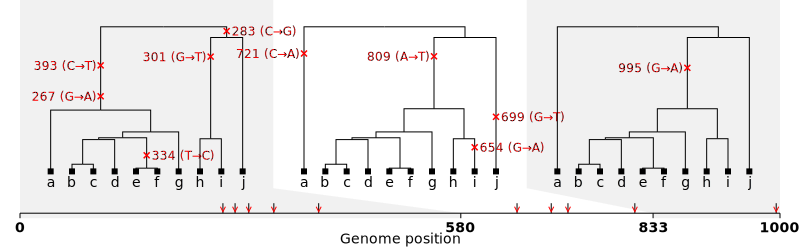

In [4]:
mut_labels = {}  # An array of labels for the mutations, listing position & allele change
l = "{:g} ({}→{})"
for mut in mutated_ts.mutations():  # This entire loop is just to make pretty labels
    site = mutated_ts.site(mut.site)
    older_mut = mut.parent >= 0  # is there an older mutation at the same position?
    prev = mutated_ts.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = l.format(site.position, prev, mut.derived_state)

SVG(mutated_ts.draw_svg(
    size=sz, style=style1, node_labels=labels, mutation_labels=mut_labels))

There are now ten single nucleotide mutations in the tree sequence. They are shown on the
branches of the trees, and the positions of the ten variable sites associated with the
mutations are shown along the X axis.

:::{margin} Key point
Mutation on trees are the source of genetic variation
:::

The trees inform us that, for example, the final mutation (at position 995) is inherited
by genomes $\mathrm{b}$ to $\mathrm{i}$. These genomes must have an *A* at that position,
compared to the original value of *G*. In other words, once we know the ancestry, placing
a relatively small number of mutations is enough to explain all the observed genetic
variation. Here's the resulting "variant matrix":

In [5]:
haplotypes = ["   ".join(h) for h in mutated_ts.haplotypes()]
print("Position: " + " ".join(str(int(s.position)) for s in mutated_ts.sites()))
print("\n".join(sorted(
    [f"Genome {labels[i]}:  {h}" for i, h in zip(mutated_ts.samples(), haplotypes)])))

Position: 267 283 301 334 393 654 699 721 809 995
Genome a:  A   C   G   T   T   G   G   A   A   G
Genome b:  A   C   G   T   T   G   G   C   T   A
Genome c:  A   C   G   T   T   G   G   C   T   A
Genome d:  A   C   G   T   T   G   G   C   T   A
Genome e:  A   C   G   C   T   G   G   C   T   A
Genome f:  A   C   G   C   T   G   G   C   T   A
Genome g:  A   C   G   T   T   G   G   C   T   A
Genome h:  G   G   T   T   C   G   G   C   T   A
Genome i:  G   G   T   T   C   A   G   C   T   A
Genome j:  G   G   G   T   C   G   T   C   A   G


This approach scales effectively to millions of genomes, and to chromosomes of
hundreds of megabases in length. The ability to deal with huge datasets comes down to
one key feature of genomic data: adjacent trees along a chromosome are highly correlated,
that is, they *share structure*. In our example this becomes evident
if we highlight the branches ("edges" in tree sequence terminology) that remain
unchanged between the first and the second tree.

(fig_what_is_edge_diffs)=

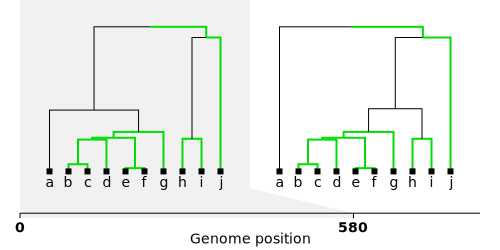

In [6]:
# Highlight certain edges in certain trees. Other visualization possibilities in tutorials/viz.html
kept_edges = [e for e in ts.edges() if e.left==0 and e.right>ts.breakpoints(True)[1]]
style3 = (
    ",".join(f"#svg1 .tree:not(.t2) .node.a{e.parent}.n{e.child} > .edge" for e in kept_edges)
    + "{stroke:#00DD00; stroke-width: 2px}"
    + style1)
SVG(ts.draw_svg(
    size=(500, 250), x_lim=(0, 800), root_svg_attributes={'id':'svg1'},  y_ticks=ticks,
    node_labels=labels, style=style3))

:::{margin} Key point
Tree sequences are efficient because they don't store each tree separately
:::

A branch can be shared by many adjacent trees, but is stored as a single edge in the tree
sequence. For large datasets this is a great saving, because typically each tree-change
affects only a few branches at a time, regardless of the tree size.

Below is an extension of the plot at the top of this page, showing predicted
file sizes when storing not just millions, but billions of human-like genomes:
enough to encompass every human on the planet. This demonstrates that the tree sequence
encoding leads to savings of many orders of magnitude, even when compared against
compressed versions of the standard VCF storage format (original published data
[here](https://www.nature.com/articles/s41588-019-0483-y/figures/1)). It's also worth
noting that the efficiency extends to processing time too: tree sequences are often
several orders of magnitude faster to process than other storage formats.

(plot_storing_everyone)=

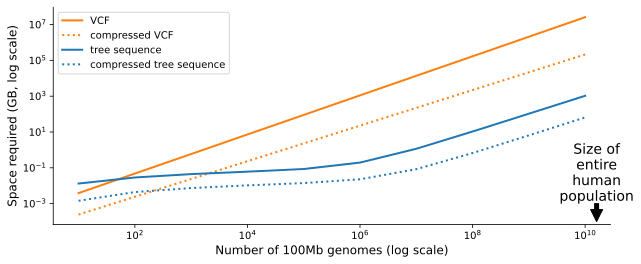

In [7]:
# This cell deliberately removed (not just hidden via a toggle) as it's not helpful
# for understanding tskit code (it's merely plotting code)
x = data1['sample_size']
fig, ax1 = plt.subplots(1, figsize=(10, 4))
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

plt.loglog(x,  data1['vcf_fit'], c="C1", label="VCF", linewidth=2)
plt.loglog(x,  data1['vcfz_fit'], c="C1", label="compressed VCF", linewidth=2, linestyle=":")

plt.loglog(x, data1['tsk_fit'], c="C0", label="tree sequence", linewidth=2)
plt.loglog(x, data1['tskz_fit'], c="C0", label="compressed tree sequence", linewidth=2, linestyle=":")

plt.xlabel('Number of 100Mb genomes (log scale)', fontsize=12)
plt.ylabel('Space required (GB, log scale)', fontsize=12)
plt.text(16e9, 0.001, 'Size of\nentire\nhuman\npopulation', ha="center", va="bottom", size=14)
plt.annotate('', xy=(16e9, 0.0001), xytext=(16e9, 0.001), 
            arrowprops=dict(facecolor='black', shrink=0))
plt.legend()
plt.show()

(sec_what_is_ancestry)=

## A record of genetic ancestry

::::{margin}
:::{note}
The genetic genealogy is sometimes referred to as an ancestral recombination graph,
or ARG, and there are {ref}`close similarities<sec_concepts_args>` between ARGs
and tree sequences (see the {ref}`ARG tutorial<sec_args>`)
:::
::::

Often, we're not interested so much in the DNA sequence data as the genetic ancestry
itself (discussed e.g. [here](https://www.nature.com/articles/s41588-019-0492-x)).
In other words, the main consideration is the actual trees in a tree sequence, rather
than the distributions of mutations placed upon them --- indeed in genetic simulations, it
{ref}`may not be necessary<sec_tskit_no_mutations>` to incorporate neutral mutations at all.
The trees reflect, for example, the origin and age of alleles under
selection, the spatial structure of populations, and the effects
of hybridization and admixture in the past.

The tree sequence in this tutorial was actually generated using a model of population
splits and expansions as shown in the following schematic,
{ref}`plotted<sec_tskit_viz_other_demographic>` using the
[DemesDraw](https://pypi.org/project/demesdraw/) package. Our 10 genomes were sampled
from modern day populations A (a constant-size population) and B (a recently expanding
one).

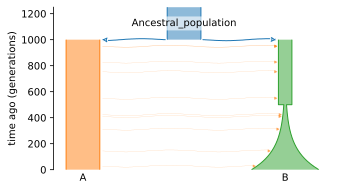

In [8]:
# This cell deliberately removed (not just hidden via a toggle) as it's not helpful
# for understanding tskit code (it's merely plotting code taken from the demesdraw docs)
import demes
import demesdraw

def size_max(graph):
    return max(
        max(epoch.start_size, epoch.end_size)
        for deme in graph.demes
        for epoch in deme.epochs
    )

graph = demes.load("data/whatis_example.yml")
w = 1.5 * size_max(graph)
positions = dict(Ancestral_population=0, A=-w, B=w)
fig, ax = plt.subplots(1, figsize=(5, 3))
ax = demesdraw.tubes(graph, ax=ax, positions=positions, seed=1)
plt.show(ax.figure)

A major benefit of "tree sequence thinking" is the close relationship between the
tree sequence and the underlying biological processes that produced the genetic
sequences in the first place, such as those pictured in the demography above. For
example, each branch point (or "internal node") in one of our trees can be
imagined as a genome which existed at a specific time in the past, and
which is a "most recent common ancestor" (MRCA) of the descendant genomes at that
position on the chromosome. We can mark these extra "ancestral genomes" on our tree
diagrams, distinguishing them from the *sampled* genomes ($\mathrm{a}$ to $\mathrm{j}$)
by using circular symbols. We can even colour the nodes by the population that we know
(or infer) them to belong to at the time:

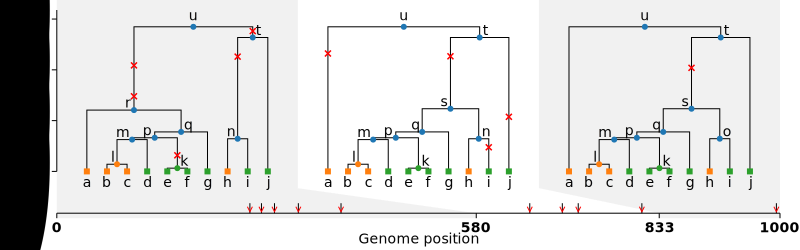

In [9]:
colours = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
style2 = ".y-axis .tick .lab {font-size: 85%}"
style2 += "#svg2 .node > .sym {visibility: visible;}"  # force-show all nodes: not normally needed
style2 += "".join([f".p{n.population} > .sym {{fill: {colours[n.population]}}}" for n in ts.nodes()])

SVG(mutated_ts.draw_svg(
    size=sz, root_svg_attributes={'id':'svg2'}, y_label="Time ago (generations)",
    y_axis=True, y_ticks=ticks, node_labels=labels, mutation_labels={}, style=style2))

The diagram shows that most of the ancestral genomes $\mathrm{k}$ to $\mathrm{u}$
lived much longer ago than the population split, 1000 generations back, and
resided in the ancestral (blue) population. The tree sequence also allows us to easily
deduce these MRCA genomes, simply by looking at which mutations they have inherited:

In [10]:
import numpy as np
tables = mutated_ts.dump_tables()
# Flip sample and nonsample flags, making the haplotypes() method print out nonsample nodes
s_flags = tables.nodes.flags[ts.samples()[0]]
no_flags = s_flags-s_flags
tables.nodes.flags = np.where(tables.nodes.flags & tskit.NODE_IS_SAMPLE, no_flags, s_flags)
ts_flipped = tables.tree_sequence()
haplotypes = ["   ".join(h) for h in ts_flipped.haplotypes(missing_data_character=" ")]
print(" " * ts_flipped.num_sites, " " * (ts_flipped.num_sites-4), "")
print(
    "||ANCESTRAL GENOMES||      Position:",
    " ".join(str(int(s.position)) for s in ts_flipped.sites()))
print(
    "\n".join(reversed(sorted([
        f"Genome {labels[i]} (time {ts.node(i).time:7.1f} in the past):  {h}"
        for i, h in zip(ts_flipped.samples(), haplotypes)]))))

                  
||ANCESTRAL GENOMES||      Position: 267 283 301 334 393 654 699 721 809 995
Genome u (time 14237.0 in the past):  G   C   G   T   C   G   G   C   A   G
Genome t (time 13183.7 in the past):  G   G   G   T   C   G   G   C   A   G
Genome s (time  6169.6 in the past):                      G   G   C   T   A
Genome r (time  6036.2 in the past):  A   C   G   T   T                    
Genome q (time  3887.8 in the past):  A   C   G   T   T   G   G   C   T   A
Genome p (time  3311.5 in the past):  A   C   G   T   T   G   G   C   T   A
Genome o (time  3218.8 in the past):                                      A
Genome n (time  3213.6 in the past):  G   G   T   T   C   G   G   C   T    
Genome m (time  3131.7 in the past):  A   C   G   T   T   G   G   C   T   A
Genome l (time   705.4 in the past):  A   C   G   T   T   G   G   C   T   A
Genome k (time   318.8 in the past):  A   C   G   C   T   G   G   C   T   A


You can see that some ancestors are missing genomic regions, because those parts of
their genome have not been inherited by any of the sampled genomes. In other words, that
ancestral node is not present in the corresponding local tree.


(sec_what_is_analysis)=

## A framework for efficient computation


Using tree structures is a common way to implement efficient computer algorithms, and
many [phylogenetic](https://en.wikipedia.org/wiki/Phylogenetics) methods use the
structure provided by the evolutionary tree to implement efficient 
[dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming)
algorithms. The tree sequence structure allows these approaches
to be extended to the particular form of
[phylogenetic network](https://en.wikipedia.org/wiki/Phylogenetic_network) defined by
multiple correlated trees along a genome.


```{margin} Key point
Most genetic calculations involve iterating over trees, which is highly efficient in
{program}`tskit`
```

For example, statistical measures of genetic variation can be thought of as a calculation
combining the local trees with the mutations on each branch (or, often preferably, the
length of the branches: see [this summary](https://www.genetics.org/content/genetics/215/3/779)).
Because a tree sequence is built on a set of small branch changes along the chromosome,
statistical calculations can often be updated incrementally as we
move along the genome, without having to perform the calculation *de novo* on each tree.
Using tree sequences can result in speed-ups of many
orders of magnitude when perfoming calculations on large datasets, as in this example of
calculating [Tajima's D](https://en.wikipedia.org/wiki/Tajima%27s_D)
(from [here](https://www.genetics.org/content/215/3/779#F9)):

(plot_incremental_calculation)=

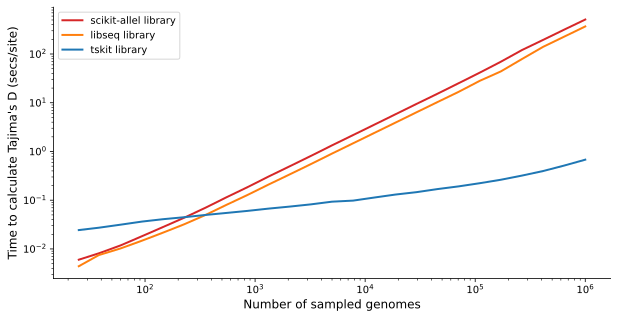

In [11]:
# This cell deliberately removed (not just hidden via a toggle) as it's not helpful
# for understanding tskit code (it's merely plotting code)
ts_time = np.array([[n,t] for s, n, t in data2[['toolkit','nsam','seconds']] if s == 'tskit'])
ska_time = np.array([[n, t] for s, n, t in data2[['toolkit','nsam','seconds']] if s == 'allel'])
libseq_time = np.array([[n, t] for s, n, t in data2[['toolkit','nsam','seconds']] if s == 'libseq'])
fig, ax1 = plt.subplots(1, figsize=(10, 5))
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.loglog(ska_time[:,0], ska_time[:,1], c="C3", linewidth=2, label="scikit-allel library")
ax1.loglog(libseq_time[:,0], libseq_time[:,1], c="C1", linewidth=2, label="libseq library")
ax1.loglog(ts_time[:,0], ts_time[:,1], c="C0", linewidth=2, label="tskit library")
ax1.set_ylabel("Time to calculate Tajima's D (secs/site)", fontsize=12)
ax1.set_xlabel("Number of sampled genomes", fontsize=12)
plt.legend()
plt.show()

The {program}`tskit` library has {ref}`extensive support<sec_analysing_tree_sequences>`
for these sorts of population genetic calculations. It provides efficient methods for
traversing through large {ref}`trees<sec_analysing_trees_traversals>` and
{ref}`tree sequences<sec_processing_trees>`, as well as providing other
phylogenetically relevant methods such as
{ref}`parsimonious placement of mutations<sec_analysing_trees_parsimony>`,
and the {ref}`counting of topologies<sec_counting_topologies>` embedded within
larger trees.

If you are new to tree sequences, and want to start finding out about {program}`tskit`,
you might now want to continue to the next tutorial: {ref}`sec_terminology_and_concepts`.


## Further reading

* Basic concepts: details in the {ref}`sec_terminology_and_concepts` tutorial
* How is a tree sequence stored: details in the {ref}`sec_tables` tutorial
* The offical {program}`tskit` [documentation](https://tskit.dev/tskit/docs)